In [13]:
import openmeteo_requests
import pandas as pd
import requests
from retry_requests import retry
from pymongo import MongoClient
import matplotlib.pyplot as plt
from datetime import datetime
today_str = datetime.now().strftime('%Y-%m-%d')

In [14]:
client = MongoClient("mongodb://localhost:27017")
db = client["weather_db"]
collection = db["new_york_hourly"]

In [15]:
retry_session = retry(requests.Session(), retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [16]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 50.1109,
    "longitude": 8.6821,
    "start_date": "2024-01-01",
    "end_date": today_str,
    "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "surface_pressure", "wind_speed_10m", "precipitation","weather_code"],
    "timezone": "America/New_York"

}
responses = openmeteo.weather_api(url, params=params)


In [17]:
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")

Coordinates: 50.08787155151367°N 8.65384578704834°E
Elevation: 103.0 m asl
Timezone difference to GMT+0: -18000s
Timezone: b'America/New_York'b'GMT-5'


In [18]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(6).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(7).ValuesAsNumpy()

data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}

data["temperature"] = hourly_temperature_2m
data["relative_humidity"] = hourly_relative_humidity_2m
data["dew_point"] = hourly_dew_point_2m
data["apparent_temperature"] = hourly_apparent_temperature
data["surface_pressure"] = hourly_surface_pressure
data["wind_speed"] = hourly_wind_speed_10m
data["precipitation"] = hourly_precipitation
data["weather_code"] = hourly_weather_code

df = pd.DataFrame(data=data)
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,surface_pressure,wind_speed,precipitation,weather_code
0,2024-01-01 05:00:00+00:00,6.315,81.123802,3.315,1.365055,994.514160,23.277834,0.0,3.0
1,2024-01-01 06:00:00+00:00,6.365,80.560051,3.265,1.303578,994.812683,23.977188,0.0,3.0
2,2024-01-01 07:00:00+00:00,6.465,78.884583,3.065,1.298761,995.409485,24.437611,0.0,3.0
3,2024-01-01 08:00:00+00:00,6.165,78.839211,2.765,0.831516,995.988464,25.202570,0.0,3.0
4,2024-01-01 09:00:00+00:00,6.765,75.650551,2.765,1.165618,996.410461,27.026386,0.0,3.0


In [19]:
df = df.round({
    'temperature': 4,
    'relative_humidity': 4,
    'dew_point': 4,
    'apparent_temperature': 4,
    'surface_pressure': 4,
    'wind_speed': 4
})
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,surface_pressure,wind_speed,precipitation,weather_code
0,2024-01-01 05:00:00+00:00,6.315,81.123802,3.315,1.3651,994.514221,23.277800,0.0,3.0
1,2024-01-01 06:00:00+00:00,6.365,80.559998,3.265,1.3036,994.812683,23.977200,0.0,3.0
2,2024-01-01 07:00:00+00:00,6.465,78.884598,3.065,1.2988,995.409485,24.437599,0.0,3.0
3,2024-01-01 08:00:00+00:00,6.165,78.839203,2.765,0.8315,995.988525,25.202600,0.0,3.0
4,2024-01-01 09:00:00+00:00,6.765,75.650597,2.765,1.1656,996.410522,27.026400,0.0,3.0


In [20]:
df.to_csv('load.csv')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16728 entries, 0 to 16727
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  16728 non-null  datetime64[ns, UTC]
 1   temperature           16728 non-null  float32            
 2   relative_humidity     16728 non-null  float32            
 3   dew_point             16728 non-null  float32            
 4   apparent_temperature  16728 non-null  float32            
 5   surface_pressure      16728 non-null  float32            
 6   wind_speed            16728 non-null  float32            
 7   precipitation         16728 non-null  float32            
 8   weather_code          16728 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(8)
memory usage: 653.6 KB


In [22]:
df.describe()

,temperature,relative_humidity,dew_point,apparent_temperature,surface_pressure,wind_speed,precipitation,weather_code
count,16728.000000,16728.000000,16728.000000,16728.000000,16728.000000,16728.000000,16728.000000,16728.000000
mean,12.098798,74.738136,7.117645,10.253374,1004.282410,9.859723,0.088421,9.952595
std,7.858143,18.089148,6.163177,9.209613,8.946369,5.677569,0.399166,18.919197
min,-7.685000,14.681700,-16.785000,-12.109500,971.440979,0.000000,0.000000,0.000000
25%,6.215000,63.476900,2.815000,3.152200,998.959595,5.781775,0.000000,1.000000
50%,11.965000,78.783501,7.415000,10.146400,1004.536316,8.891300,0.000000,3.000000
75%,17.715000,89.390676,11.865000,16.913900,1010.155518,12.822050,0.000000,3.000000
max,38.314999,100.000000,21.215000,38.705799,1030.605713,35.496101,14.600000,75.000000


In [23]:
collection.delete_many({})
records = df.to_dict(orient="records")
if records:
    collection.insert_many(records)
else:
    print("No data to insert")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4888\3655235645.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[['temperature', 'relative_humidity', 'dew_point', 'apparent_temperature', 'surface_pressure', 'wind_speed', 'precipitation']].plot.line(subplots=True, ax=ax)


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

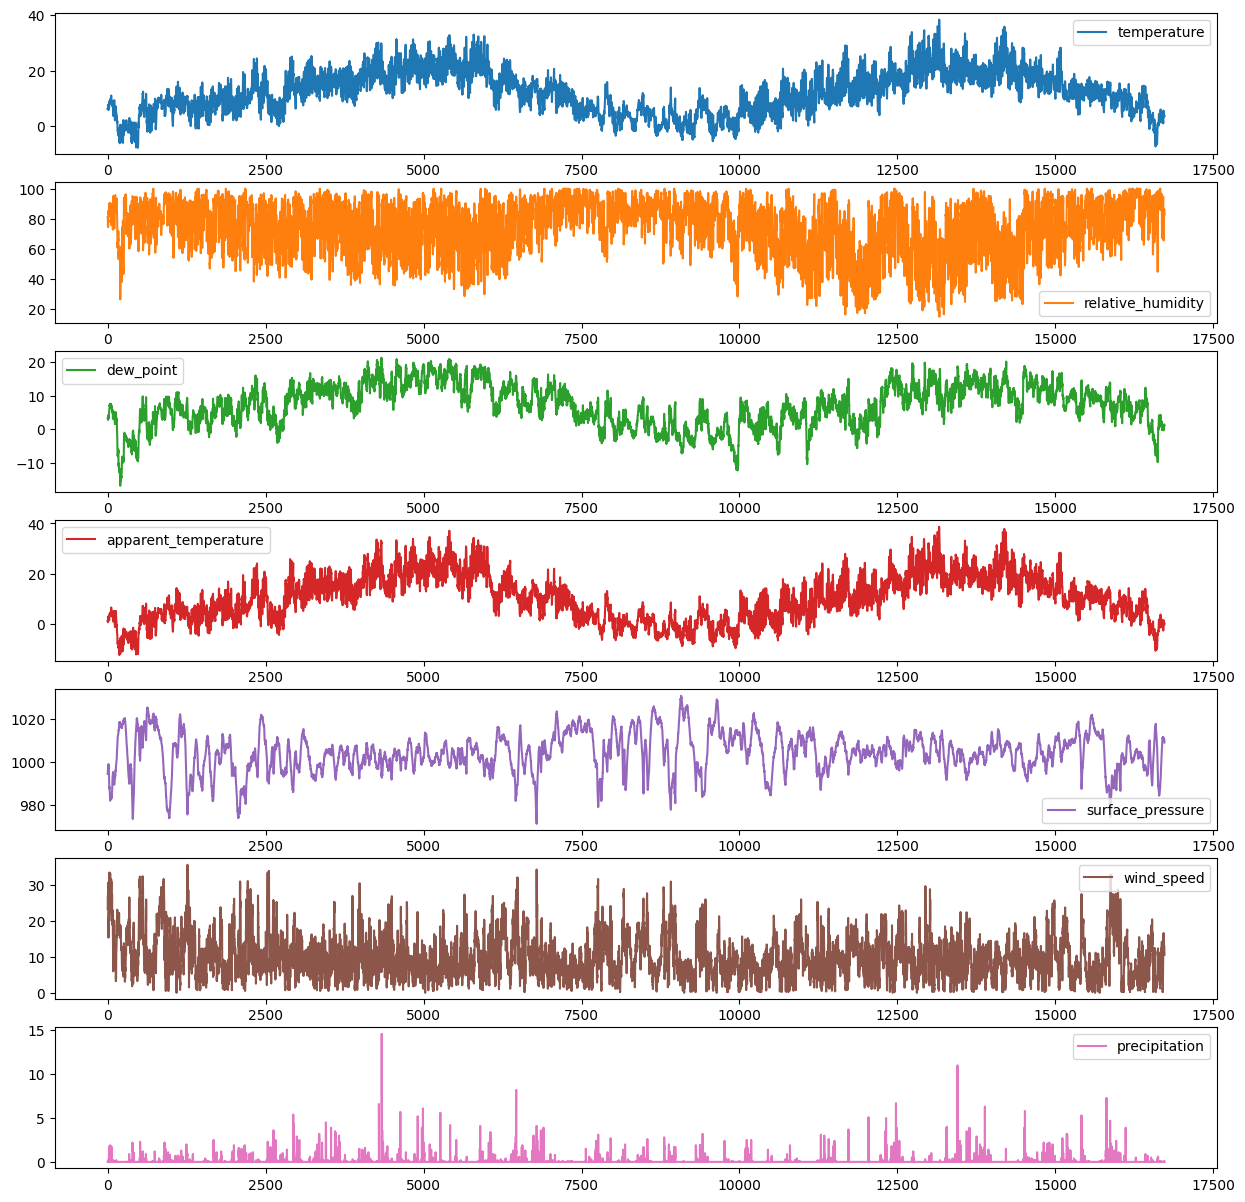

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))
df[['temperature', 'relative_humidity', 'dew_point', 'apparent_temperature', 'surface_pressure', 'wind_speed', 'precipitation']].plot.line(subplots=True, ax=ax)